<a href="https://colab.research.google.com/github/alslmini/Machine-Learning-Programming/blob/main/20251104%EC%8B%A4%EC%8A%B5/CNN_Smartphone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# --- 데이터 로드 함수들 (변경 없음) ---

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        # 파일 경로가 올바른지 확인을 위해 prefix + name을 출력해볼 수도 있습니다.
        # print(prefix + name)
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'

    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']

    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# --- load_dataset 함수 (경로 수정) ---

def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix)
    # load all test
    testX, testy = load_dataset_group('test', prefix)

    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print(f"trainX: {trainX.shape}, trainy: {trainy.shape}, trainy_one_hot: {trainy_one_hot.shape}")
    print(f"testX: {testX.shape}, testy: {testy.shape}, testy_one_hot: {testy_one_hot.shape}")
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

DATASET_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/Machine-Learning/20251104/UCI HAR Dataset/'

print("데이터셋 로드 중...")
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(DATASET_ROOT_PATH)
print("데이터셋 로드 완료.")

# train 데이터를 학습/검증 셋으로 분리
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

print("\n--- 학습/검증 셋 분리 결과 ---")
print(f"X_train.shape: {X_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_train_one_hot.shape: {y_train_one_hot.shape}")
print(f"y_val_one_hot.shape: {y_val_one_hot.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_val.shape: {y_val.shape}")

데이터셋 로드 중...


/tmp/ipython-input-3962955643.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3962955643.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3962955643.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3962955643.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=Tr

trainX: (7352, 128, 9), trainy: (7352, 1), trainy_one_hot: (7352, 6)
testX: (2947, 128, 9), testy: (2947, 1), testy_one_hot: (2947, 6)
데이터셋 로드 완료.

--- 학습/검증 셋 분리 결과 ---
X_train.shape: (5881, 128, 9)
X_val.shape: (1471, 128, 9)
y_train_one_hot.shape: (5881, 6)
y_val_one_hot.shape: (1471, 6)
y_train.shape: (5881, 1)
y_val.shape: (1471, 1)


In [6]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, concatenate
)

# 이전 코드에서 계산된 변수:
# n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]
# 현재 값: n_timesteps=128, n_features=9, n_outputs=6 (UCI HAR 기준)

# --- 1. 단일 입력 레이어 정의 ---
inputs = Input(shape=(n_timesteps, n_features))
common_input = inputs # 모든 병렬 Conv1D가 이 입력을 사용합니다.

## Level_1 (Multi-Kernel Block 1)
# layer 1
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(common_input)
# layer 2
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(common_input)
# layer 3
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(common_input)
# layer 4
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(common_input)

# merge1: 특징 맵(Feature Maps) 축(axis=-1)을 따라 병합 (128+128+128+128 = 512 채널)
# Conv1D 연산 후 출력 시퀀스 길이는 필터 크기에 따라 다를 수 있으나, Keras의 기본 Padding='valid'를
# 사용하면 길이가 짧아지므로, 이를 병합하려면 'same' padding을 사용하거나 길이를 맞춰야 합니다.

# **주의:** 현재 코드는 padding 설정이 없어서 길이가 다르게 나옵니다.
# Conv1D(..., padding='same')을 사용하는 것이 병합에 가장 안전하지만, 원본 코드의 의도를 따라
# 길이를 줄이는 방식(valid)으로 유지하고, 병합 축을 feature axis (-1)로 수정합니다.
# 다만, 길이가 달라 병합이 실패할 수 있으므로, *길이를 맞추는* 'same' padding을 추천합니다.

# 안전한 병합을 위해 'padding='same''을 적용하는 것을 강력히 권장합니다.
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(common_input)
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(common_input)
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu', padding='same')(common_input)
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu', padding='same')(common_input)

# 병합: 특징 축(axis=-1)을 따라
merged_1 = concatenate([conv1_1, conv1_2, conv1_3, conv1_4], axis=-1)
# maxpool1
pool_1 = MaxPooling1D(pool_size=5)(merged_1)


## Level_2 (Multi-Kernel Block 2)
# layer 1
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(pool_1)
# layer 2
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(pool_1)
# layer 3
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu', padding='same')(pool_1)
# layer 4
conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu', padding='same')(pool_1)

# merge2: 특징 축(axis=-1)을 따라 병합 (64*4 = 256 채널)
merged_2 = concatenate([conv2_1, conv2_2, conv2_3, conv2_4], axis=-1)
# maxpool2
pool_2 = MaxPooling1D(pool_size=5)(merged_2)


## Level_3 (Multi-Kernel Block 3)
# layer 1
conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(pool_2)
# layer 2
conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(pool_2)
# layer 3
conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu', padding='same')(pool_2)
# layer 4
conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu', padding='same')(pool_2)

# merge3: 특징 축(axis=-1)을 따라 병합 (32*4 = 128 채널)
merged_3 = concatenate([conv3_1, conv3_2, conv3_3, conv3_4], axis=-1)
# maxpool3
pool_3 = MaxPooling1D(pool_size=5)(merged_3)

# flatten
flat_cnn = Flatten()(pool_3)

## dense layer
dense = Dense(512, activation='relu')(flat_cnn)
outputs = Dense(n_outputs, activation='softmax')(dense)

## MODEL (단일 입력 사용)
cnn3_model = Model(inputs=inputs, outputs=outputs)

cnn3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn3_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 128, 128)  │      3,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 128, 128)  │      5,888 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 128, 128)  │      8,192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 128, 128)  │     10,496 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 512)  │          0 │ conv1d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 25, 512)   │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 25, 64)    │     98,368 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 25, 64)    │    163,904 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 25, 64)    │    229,440 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 25, 64)    │    294,976 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 25, 256)   │          0 │ conv1d_8[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_9[0][0],   │
│                     │                   │            │ conv1d_10[0][0],  │
│                     │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 5, 256)    │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 5, 32)     │     24,608 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 5, 32)     │     40,992 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 5, 32)     │     57,376 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 5, 32)     │     73,760 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 5, 128)    │          0 │ conv1d_12[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_13[0][0],  │
│                     │                   │            │ conv1d_14[0][0],  │
│                     │                   │            │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1, 128)    │          0 │ concatenate_2[0]

 Total params: 1,080,710 (4.12 MB)

 Trainable params: 1,080,710 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model_history = cnn3_model.fit(
    x=X_train,
    y=y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot)
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9641 - loss: 0.1354 - val_accuracy: 0.9646 - val_loss: 0.0894
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9686 - loss: 0.0720 - val_accuracy: 0.9653 - val_loss: 0.0909
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9735 - loss: 0.0583 - val_accuracy: 0.9769 - val_loss: 0.0626
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9714 - loss: 0.0661 - val_accuracy: 0.9585 - val_loss: 0.1153
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9738 - loss: 0.0618 - val_accuracy: 0.9796 - val_loss: 0.0574
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9752 - loss: 0.0544 - val_accuracy: 0.9789 - val_loss: 0.0508
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9859 - loss: 0.0340 - val_accuracy: 0.9823 - val_loss: 0.0446
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9832 - loss: 0.0393 - val_accuracy:

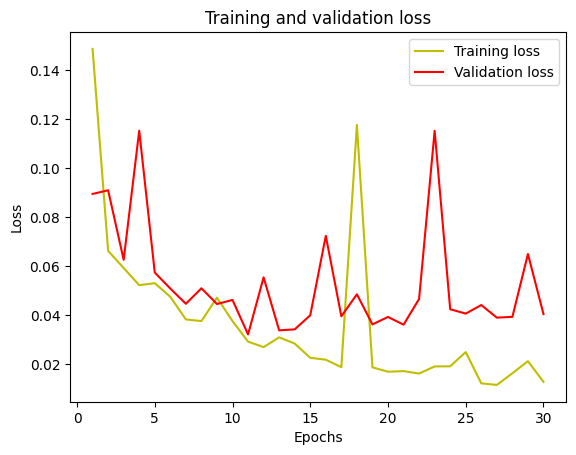

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

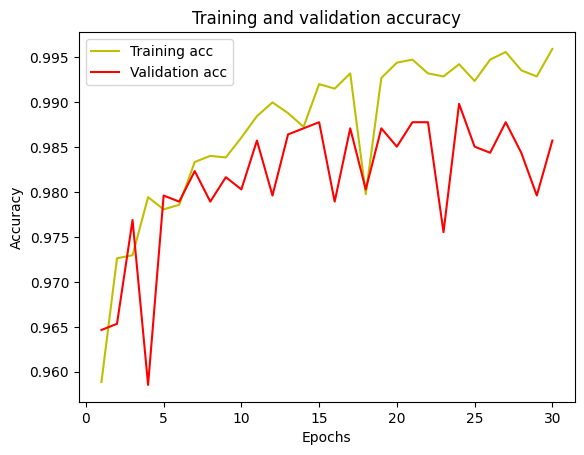

In [11]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
--- Confusion Matrix ---
[[465  12  19   0   0   0]
 [  0 468   3   0   0   0]
 [  2  14 404   0   0   0]
 [  0   4   0 415  66   6]
 [  0   3   0  25 504   0]
 [  0   0   0   0   0 537]]

--- Accuracy Score ---
0.9477434679334917

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       496
           1       0.93      0.99      0.96       471
           2       0.95      0.96      0.96       420
           3       0.94      0.85      0.89       491
           4       0.88      0.95      0.91       532
           5       0.99      1.00      0.99       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



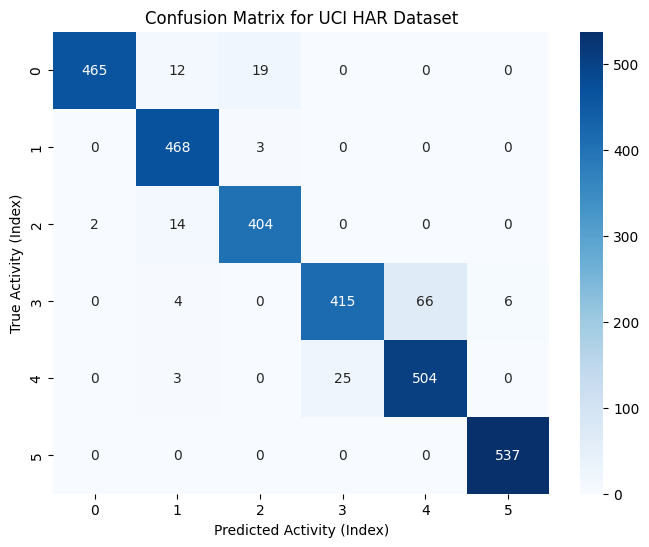

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 예측 단계 수정 (가장 중요한 부분!) ---
# 단일 입력 모델이므로 testX 하나만 전달해야 합니다.
pred_probs = cnn3_model.predict(testX)
# ----------------------------------------

# 확률(Probability)을 클래스 인덱스(Index)로 변환
pred = np.argmax(pred_probs, axis=-1)

# Confusion Matrix 계산
cm = confusion_matrix(testy, pred)

# 결과 출력 및 시각화
print("--- Confusion Matrix ---")
print(cm)
print("\n--- Accuracy Score ---")
print(accuracy_score(testy, pred))
print("\n--- Classification Report ---")
# Classification Report는 정밀도, 재현율, F1-score 등을 보여줍니다.
print(classification_report(testy, pred))

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt = 'd', cmap='Blues') # 정수형 카운트이므로 fmt='d'가 더 명확합니다.
plt.title('Confusion Matrix for UCI HAR Dataset')
plt.ylabel('True Activity (Index)')
plt.xlabel('Predicted Activity (Index)')
plt.show()